In [23]:
%matplotlib inline
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

from collections import Counter

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)


dataset_path = 'wasteData'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

In [24]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [25]:
categories


[{'supercategory': 'Aluminium foil', 'id': 0, 'name': 'Aluminium foil'},
 {'supercategory': 'Battery', 'id': 1, 'name': 'Battery'},
 {'supercategory': 'Blister pack', 'id': 2, 'name': 'Aluminium blister pack'},
 {'supercategory': 'Blister pack', 'id': 3, 'name': 'Carded blister pack'},
 {'supercategory': 'Bottle', 'id': 4, 'name': 'Other plastic bottle'},
 {'supercategory': 'Bottle', 'id': 5, 'name': 'Clear plastic bottle'},
 {'supercategory': 'Bottle', 'id': 6, 'name': 'Glass bottle'},
 {'supercategory': 'Bottle cap', 'id': 7, 'name': 'Plastic bottle cap'},
 {'supercategory': 'Bottle cap', 'id': 8, 'name': 'Metal bottle cap'},
 {'supercategory': 'Broken glass', 'id': 9, 'name': 'Broken glass'},
 {'supercategory': 'Can', 'id': 10, 'name': 'Food Can'},
 {'supercategory': 'Can', 'id': 11, 'name': 'Aerosol'},
 {'supercategory': 'Can', 'id': 12, 'name': 'Drink can'},
 {'supercategory': 'Carton', 'id': 13, 'name': 'Toilet tube'},
 {'supercategory': 'Carton', 'id': 14, 'name': 'Other carton'

In [26]:
anns_to_print = anns[0].pop('segmentation', None) # removing segmentation polygon for better clarity
anns[0]

{'id': 1,
 'image_id': 0,
 'category_id': 6,
 'area': 403954.0,
 'bbox': [517.0, 127.0, 447.0, 1322.0],
 'iscrowd': 0}

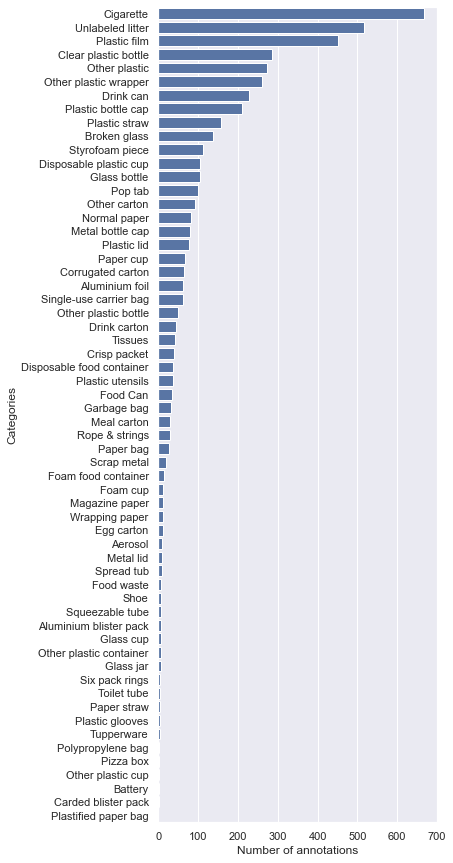

In [27]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")

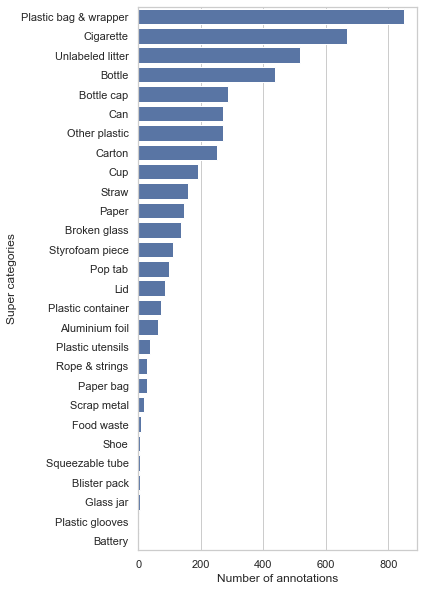

In [28]:
cat_ids_2_supercat_ids = {}
for cat in categories:
    cat_ids_2_supercat_ids[cat['id']] = super_cat_ids[cat['supercategory']]

# Count annotations
super_cat_histogram = np.zeros(nr_super_cats,dtype=int)
for ann in anns:
    cat_id = ann['category_id']
    super_cat_histogram[cat_ids_2_supercat_ids[cat_id]] +=1
    
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': super_cat_names, 'Number of annotations': super_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total", color="b")

In [29]:
# convert taco label to detect-waste labels
# based on polish recycling standards
def taco_to_detectwaste(label):
    glass = ['Glass bottle','Broken glass','Glass jar']
    metals_and_plastics = ['Aluminium foil', "Clear plastic bottle","Other plastic bottle",
                         "Plastic bottle cap","Metal bottle cap","Aerosol","Drink can",
                         "Food can","Drink carton","Disposable plastic cup","Other plastic cup",
                         "Plastic lid","Metal lid","Single-use carrier bag","Polypropylene bag",
                         "Plastic Film","Six pack rings","Spread tub","Tupperware",
                         "Disposable food container","Other plastic container",
                         "Plastic glooves","Plastic utensils","Pop tab","Scrap metal",
                         "Plastic straw","Other plastic", "Plastic film", "Food Can"]
    
    non_recyclable = ["Aluminium blister pack","Carded blister pack",
                    "Meal carton","Pizza box","Cigarette","Paper cup",
                    "Meal carton","Foam cup","Glass cup","Wrapping paper",
                    "Magazine paper","Garbage bag","Plastified paper bag",
                    "Crisp packet","Other plastic wrapper","Foam food container",
                    "Rope","Shoe","Squeezable tube","Paper straw","Styrofoam piece", "Rope & strings", "Tissues"]
    
    other = ["Battery"]
    paper = ["Corrugated carton","Egg carton","Toilet tube","Other carton", "Normal paper", "Paper bag"]
    bio = ["Food waste"]
    unknown = ["Unlabeled litter"]

    if (label in glass):
            label="glass"
    elif (label in metals_and_plastics):
            label="metals_and_plastics"
    elif(label in non_recyclable):
            label="non-recyclable"
    elif(label in other):
            label="other"
    elif (label in paper):
            label="paper"
    elif(label in bio):
            label="bio"
    elif(label in unknown):
            label="unknown"
    else:
        print(label, "is non-taco label")
        label = "unknown"
    return label

In [30]:
# convert all taco anns to detect-waste anns
# let's change supercategory to detect waste
detectwaste_categories = dataset['categories']
for ann in anns:
    cat_id = ann['category_id']
    cat_taco = categories[cat_id]['name']
    detectwaste_categories[cat_id]['supercategory'] = taco_to_detectwaste(cat_taco)
# As there is no representation of "Plastified paper bag" in annotated data, change of this supercategory was done manually.
detectwaste_categories[35]['supercategory'] = taco_to_detectwaste("Plastified paper bag")
detectwaste_categories

[{'supercategory': 'metals_and_plastics', 'id': 0, 'name': 'Aluminium foil'},
 {'supercategory': 'other', 'id': 1, 'name': 'Battery'},
 {'supercategory': 'non-recyclable',
  'id': 2,
  'name': 'Aluminium blister pack'},
 {'supercategory': 'non-recyclable', 'id': 3, 'name': 'Carded blister pack'},
 {'supercategory': 'metals_and_plastics',
  'id': 4,
  'name': 'Other plastic bottle'},
 {'supercategory': 'metals_and_plastics',
  'id': 5,
  'name': 'Clear plastic bottle'},
 {'supercategory': 'glass', 'id': 6, 'name': 'Glass bottle'},
 {'supercategory': 'metals_and_plastics',
  'id': 7,
  'name': 'Plastic bottle cap'},
 {'supercategory': 'metals_and_plastics', 'id': 8, 'name': 'Metal bottle cap'},
 {'supercategory': 'glass', 'id': 9, 'name': 'Broken glass'},
 {'supercategory': 'metals_and_plastics', 'id': 10, 'name': 'Food Can'},
 {'supercategory': 'metals_and_plastics', 'id': 11, 'name': 'Aerosol'},
 {'supercategory': 'metals_and_plastics', 'id': 12, 'name': 'Drink can'},
 {'supercategory'

In [31]:
detectwaste_ids = {}
detectwaste_cat_names = []
cat_id = 0
for cat in detectwaste_categories:
    if cat['supercategory'] not in detectwaste_ids:
        detectwaste_cat_names.append(cat['supercategory'])
        detectwaste_ids[cat['supercategory']] = cat_id
        cat_id += 1
        
print(detectwaste_ids)
print(detectwaste_cat_names)

taco_to_detectwaste_ids = {}
for i, cat in enumerate(detectwaste_categories):
#     if cat['id'] not in taco_to_detectwaste_ids:
#         taco_to_detectwaste_ids[cat['id']] = 0
    taco_to_detectwaste_ids[cat['id']] = detectwaste_ids[cat['supercategory']]
    
# print(taco_to_detectwaste_ids)

colors_recykling = ['yellow', 'gray', 'gray', 'green', 'blue', 'brown', 'pink']

anns_detectwaste = anns.copy()
for i, ann in enumerate(anns):
    #print(ann['category_id'])
    anns_detectwaste[i]['category_id'] = taco_to_detectwaste_ids[ann['category_id']]
    anns_detectwaste[i].pop('segmentation', None)

{'metals_and_plastics': 0, 'other': 1, 'non-recyclable': 2, 'glass': 3, 'paper': 4, 'bio': 5, 'unknown': 6}
['metals_and_plastics', 'other', 'non-recyclable', 'glass', 'paper', 'bio', 'unknown']


Text(0.5, 1.0, 'Annotations per detectwaste category')

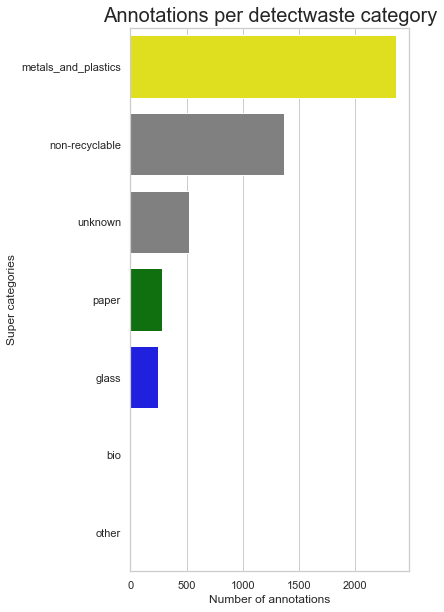

In [32]:
# Count annotations
detectwaste_cat_histogram = np.zeros(len(detectwaste_cat_names),dtype=int)

for ann in anns_detectwaste:
    cat_id = ann['category_id']
    detectwaste_cat_histogram[cat_id] +=1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': detectwaste_cat_names, 'Number of annotations': detectwaste_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)


sns.set_palette(sns.color_palette(colors_recykling))
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total")
plot_1.set_title('Annotations per detectwaste category',fontsize=20)


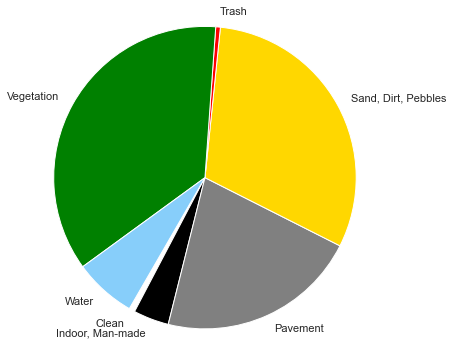

In [33]:
scene_cats = dataset['scene_categories']
scene_name = []
pylab.rcParams['figure.figsize'] = (6,6)

for scene_cat in scene_cats:
    scene_name.append(scene_cat['name'])

nr_scenes = len(scene_cats)
scene_cat_histogram = np.zeros(nr_scenes,dtype=int)

for scene_ann in dataset['scene_annotations']:    
    scene_ann_ids = scene_ann['background_ids']
    for scene_ann_id in scene_ann_ids:
        if scene_ann_id<len(scene_cats):
            scene_cat_histogram[scene_ann_id]+=1

# Plot
colors = ['white','black','gray', 'gold', 'red','green','lightskyblue']
plt.pie(scene_cat_histogram, labels=scene_name, colors = colors,
      shadow=False, startangle=-120)
 
plt.axis('equal')
plt.show()

In [34]:
def extract_detectwaste_color(ann, taco_to_detectwaste_ids, colors_recykling):
    color_id = taco_to_detectwaste_ids[ann['category_id']]
    color = colors_recykling[color_id]
    return color

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
batch_11/000028.jpg


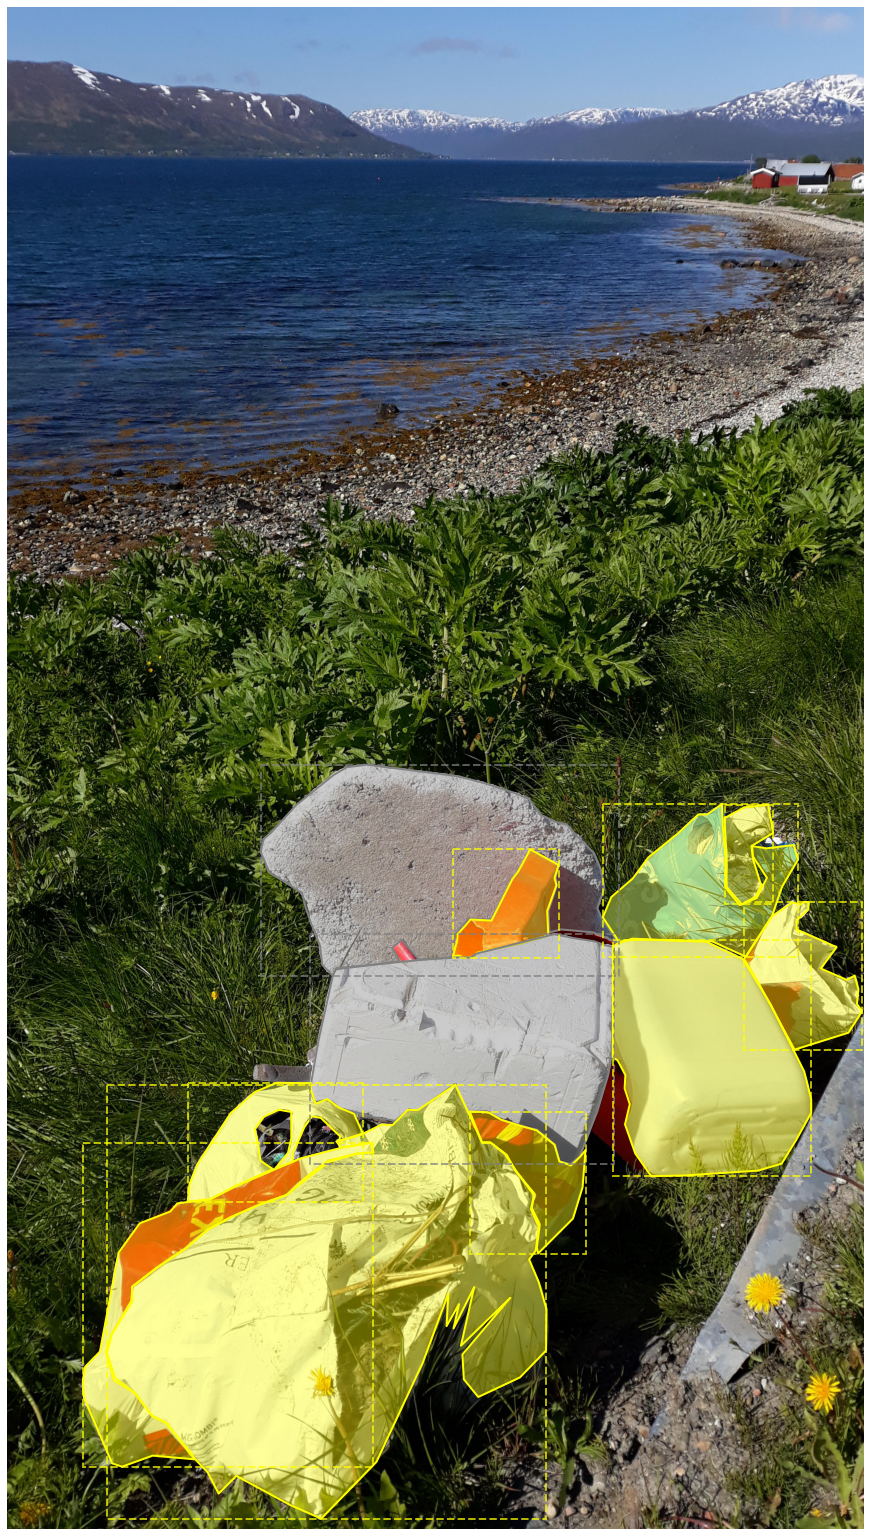

In [35]:
# User settings
image_filepath = 'batch_11/000028.jpg'
pylab.rcParams['figure.figsize'] = (28,28)
####################
imgs = dataset['images']

# Obtain Exif orientation tag code
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break

# Loads dataset as a coco object
coco = COCO(anns_file_path)

# Find image id
img_id = -1
for img in imgs:
    if img['file_name'] == image_filepath:
        img_id = img['id']
        break

# Show image and corresponding annotations
if img_id == -1:
    print('Incorrect file name')
else:

    # Load image
    print(image_filepath)
    I = Image.open(dataset_path + '/' + image_filepath)

    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)
    # Show image
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    # Load mask ids
    annIds = coco.getAnnIds(imgIds=img_id, catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)

    # Show annotations
    for ann in anns_sel:
        color = extract_detectwaste_color(ann, taco_to_detectwaste_ids, colors_recykling)
        for seg in ann['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        [x, y, w, h] = ann['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Number of images found:  322


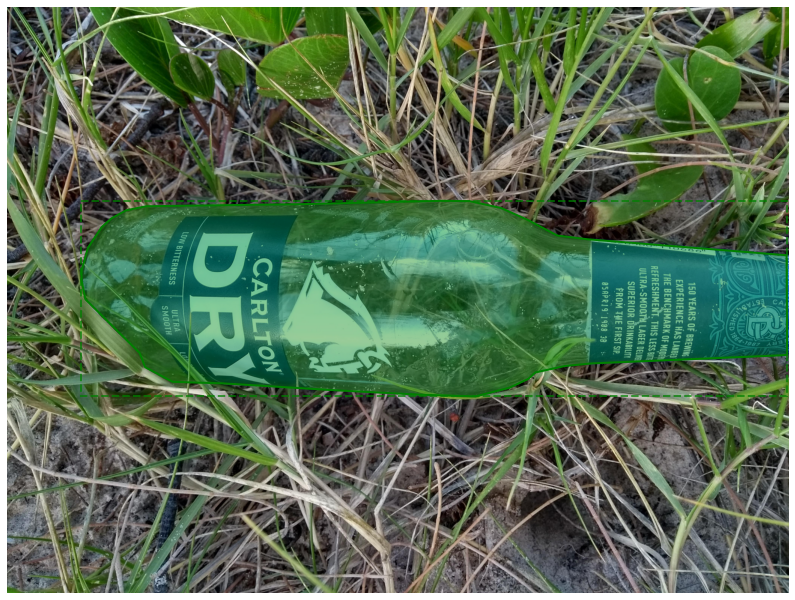

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Number of images found:  6


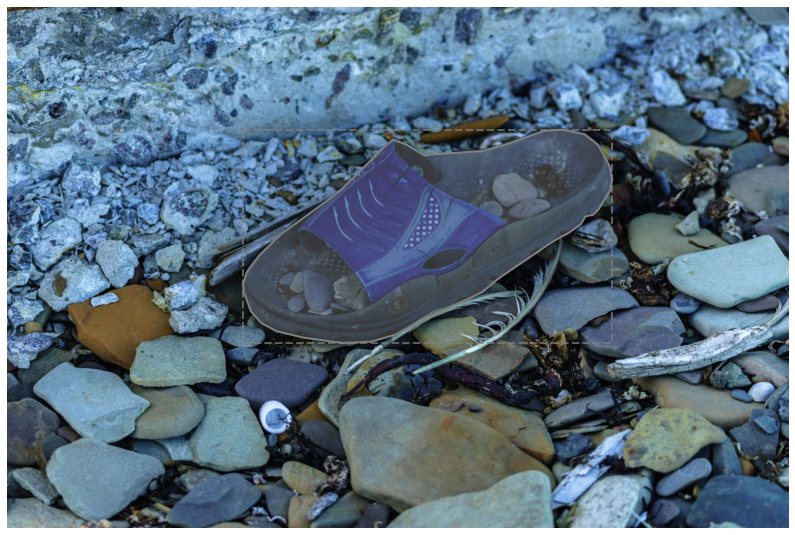

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Number of images found:  7


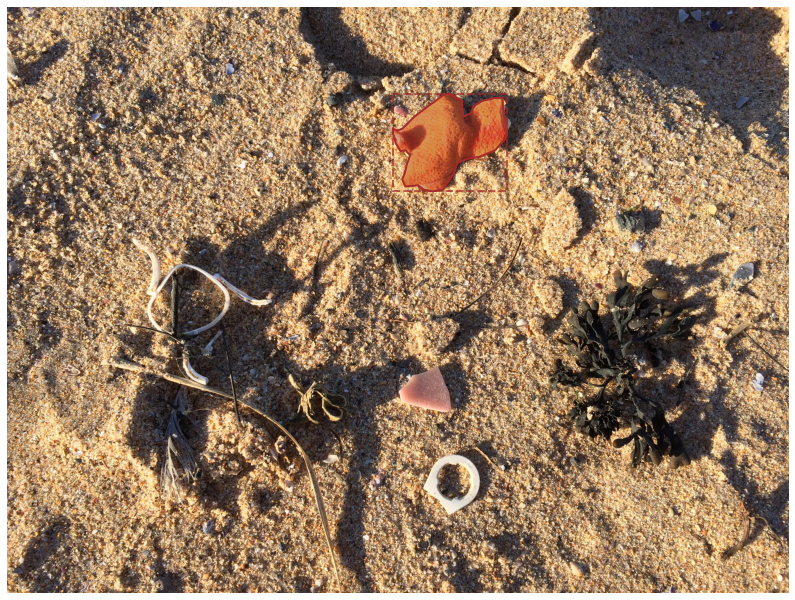

In [36]:
categories_to_show = ['Bottle', 'Shoe', 'Food waste']
nr_img_2_display = 1
pylab.rcParams['figure.figsize'] = (14,14)

for category_name in categories_to_show: #  --- Insert the name of one of the categories or super-categories above

    # Obtain Exif orientation tag code
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation] == 'Orientation':
            break

    # Loads dataset as a coco object
    coco = COCO(anns_file_path)

    # Get image ids
    imgIds = []
    catIds = coco.getCatIds(catNms=[category_name])
    if catIds:
        # Get all images containing an instance of the chosen category
        imgIds = coco.getImgIds(catIds=catIds)
    else:
        # Get all images containing an instance of the chosen super category
        catIds = coco.getCatIds(supNms=[category_name])
        for catId in catIds:
            imgIds += (coco.getImgIds(catIds=catId))
        imgIds = list(set(imgIds))

    nr_images_found = len(imgIds) 
    print('Number of images found: ',nr_images_found)

    # Select N random images
    random.shuffle(imgIds)
    imgs = coco.loadImgs(imgIds[0:min(nr_img_2_display,nr_images_found)])

    for img in imgs:
        image_path = dataset_path + '/' + img['file_name']
        # Load image
        I = Image.open(image_path)

        # Load and process image metadata
        if I._getexif():
            exif = dict(I._getexif().items())
            # Rotate portrait and upside down images if necessary
            if orientation in exif:
                if exif[orientation] == 3:
                    I = I.rotate(180,expand=True)
                if exif[orientation] == 6:
                    I = I.rotate(270,expand=True)
                if exif[orientation] == 8:
                    I = I.rotate(90,expand=True)

        # Show image
        fig,ax = plt.subplots(1)
        plt.axis('off')
        plt.imshow(I)

        # Load mask ids
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
        anns_sel = coco.loadAnns(annIds)

        # Show annotations
        for ann in anns_sel:
            color = extract_detectwaste_color(ann, taco_to_detectwaste_ids, colors_recykling)
            for seg in ann['segmentation']:
                poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
                p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
                ax.add_collection(p)
                p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
                ax.add_collection(p)
            [x, y, w, h] = ann['bbox']
            rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                             facecolor='none', alpha=0.7, linestyle = '--')
            ax.add_patch(rect)

        plt.show()